### Regression on the whole dataset all variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
hdb_df = pd.read_csv('data/hdb_combined_clean.csv', low_memory=False)

In [7]:
# Convert categorical columns to numerical
categorical_cols = ['town', 'flat_type', 'flat_model']  # Replace with relevant column names
df_encoded = pd.get_dummies(hdb_df, columns=categorical_cols, drop_first=True)

df_encoded.drop(['month_of_sale', 'block', 'street_name', 'storey_range', 'lease_commence_date', 'address',
             'latitude', 'longitude','price_per_sqm'],
            axis=1, inplace=True)

df_encoded = df_encoded.drop_duplicates()

In [8]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906790 entries, 0 to 917392
Data columns (total 62 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   floor_area_sqm                     906790 non-null  float64
 1   resale_price                       906790 non-null  float64
 2   nearest_supermarket_distance       906790 non-null  float64
 3   nearest_school_distance            906790 non-null  float64
 4   nearest_mrt_distance               906790 non-null  float64
 5   nearest_hawkers_distance           906790 non-null  float64
 6   cbd_distance                       906790 non-null  float64
 7   year_of_sale                       906790 non-null  int64  
 8   calculated_remaining_lease         906790 non-null  float64
 9   storey_median                      906790 non-null  int64  
 10  town_BEDOK                         906790 non-null  uint8  
 11  town_BISHAN                        9067

In [9]:
# Split features and target (assuming 'resale_price' is the target)
X = df_encoded.drop(columns=['resale_price'])
y = df_encoded['resale_price']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features (only for models sensitive to scale like linear regression or neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=0, ccp_alpha=0.01)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)
print("Decision Tree:")
print(f"  R²: {r2_score(y_test, dt_pred):.4f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, dt_pred)):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, dt_pred):.4f}\n")

Decision Tree:
  R²: 0.9668
  RMSE: 30565.6249
  MAE: 21166.4380



In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", np.sqrt(-scores.mean()))


Cross-validated RMSE: 31409.88606549861


In [20]:
print(f"Tree Depth: {dt.get_depth()}")
print(f"Number of Leaves: {dt.get_n_leaves()}")
# print(f"State: {dt.get_random_state()}")

Tree Depth: 55
Number of Leaves: 559322


In [24]:
from sklearn.decomposition import PCA

# Step 2: Apply PCA (choosing 55 components as an example)
pca = PCA(n_components=60)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 3: Fit a regression model
reg = LinearRegression()
reg.fit(X_train_pca, y_train)

# Step 4: Make predictions and evaluate performance
y_pred = reg.predict(X_test_pca)
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")


R²: 0.8425
RMSE: 66542.8408


In [25]:
pca = PCA().fit(X_train_scaled)
print(np.cumsum(pca.explained_variance_ratio_))  # Cumulative variance explained


[0.06844144 0.11099715 0.1487042  0.18167696 0.21192549 0.23990325
 0.26503897 0.28923775 0.31206299 0.33466604 0.35675097 0.37782149
 0.39812193 0.41769476 0.43684841 0.45563681 0.47421164 0.49225453
 0.51014843 0.52778618 0.54524704 0.56267363 0.58001925 0.59718376
 0.61419874 0.63116474 0.64805052 0.66489482 0.68163866 0.69819008
 0.71467393 0.73107176 0.74744782 0.76380073 0.78003536 0.79612625
 0.81191723 0.82759675 0.8430509  0.85798836 0.87279035 0.88723757
 0.90068919 0.9139951  0.92642545 0.9385135  0.94987267 0.96105557
 0.97163403 0.98059619 0.98819577 0.99382489 0.9964825  0.99794274
 0.99870756 0.99931555 0.9997391  0.99997391 0.99999726 1.
 1.        ]


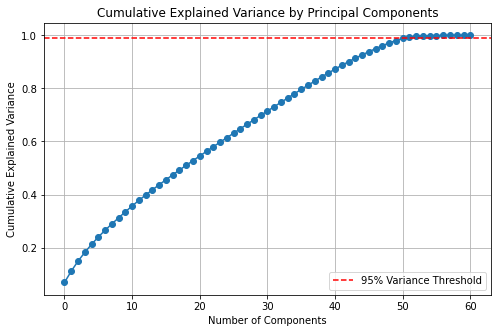

Number of components to keep for 99.0% variance: 52
Transformed shape with high variance features: (725432, 52)


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Step 2: Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Step 3: Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.99, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.show()

# Step 5: Identify high variance components (based on cumulative variance threshold)
threshold = 0.99  # Change this threshold if needed
n_components_to_keep = np.argmax(np.cumsum(explained_variance) >= threshold) + 1
print(f"Number of components to keep for {threshold*100}% variance: {n_components_to_keep}")

# Step 6: Apply PCA again, keeping only the selected number of components
pca_high_var = PCA(n_components=n_components_to_keep)
X_high_var = pca_high_var.fit_transform(X_train_scaled)

# Output the shape of the transformed data
print(f"Transformed shape with high variance features: {X_high_var.shape}")
